# Analysis

**Hypothesis**: We hypothesize that male and female patients with COVID‐19 exhibit distinct transcriptional profiles in key peripheral immune cells (CD14 Monocytes, CD16 Monocytes, CD4 T cells, and CD8 T cells). Specifically, we expect that male cells will exhibit an augmented pro-inflammatory transcriptional signature relative to female cells, potentially contributing to the observed differences in disease outcomes.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


Loading data...


Data loaded: 44721 cells and 26361 genes


# Analysis Plan

**Hypothesis**: We hypothesize that male and female patients with COVID‐19 exhibit distinct transcriptional profiles in key peripheral immune cells (CD14 Monocytes, CD16 Monocytes, CD4 T cells, and CD8 T cells). Specifically, we expect that male cells will exhibit an augmented pro-inflammatory transcriptional signature relative to female cells, potentially contributing to the observed differences in disease outcomes.

## Steps:
1. Step 1: Subset the AnnData object to retain only COVID-19 patient samples and isolate the cell types of interest (CD14 Monocytes, CD16 Monocytes, CD4 T cells, and CD8 T cells) from the 'cell_type_coarse' annotation. Use regular (non-byte) strings for robust filtering and incorporate multiple pattern matches for COVID status.
2. Step 2: Perform an exploratory quality control analysis by comparing the distribution of cells by Sex within the selected cell types. This will include printing summaries as well as generating visualizations (bar plots for cell counts and boxplots for key QC metrics like nCount_RNA and percent_mt) to detect potential biases.
3. Step 3: For each selected cell type, conduct a differential expression analysis comparing male versus female cells using the Wilcoxon rank-sum test, applying multiple-testing correction (e.g., using adjusted p-value thresholds) and reporting effect sizes along with confidence intervals.
4. Step 4: Visualize the differential expression results using volcano plots (log fold changes vs. -log10(p-value)) and heatmaps to depict the expression profiles of the top significant genes across cells arranged by sex.
5. Step 5: Validate the observed transcriptional differences by statistically assessing additional metrics (such as effect sizes and confidence intervals) and correlating key inflammatory markers (e.g., TNF, IL1B, IL6) with sex. Statistical test results should be printed for significance evaluation.
6. Step 6: Summarize and interpret the overall results to evaluate whether the sex-specific transcriptional differences in these immune cell subsets may underlie differential COVID-19 outcomes, ensuring a novel computational approach that builds on previous findings.


Cell counts by cell type and Sex in COVID-19 samples:
Empty DataFrame
Columns: []
Index: []


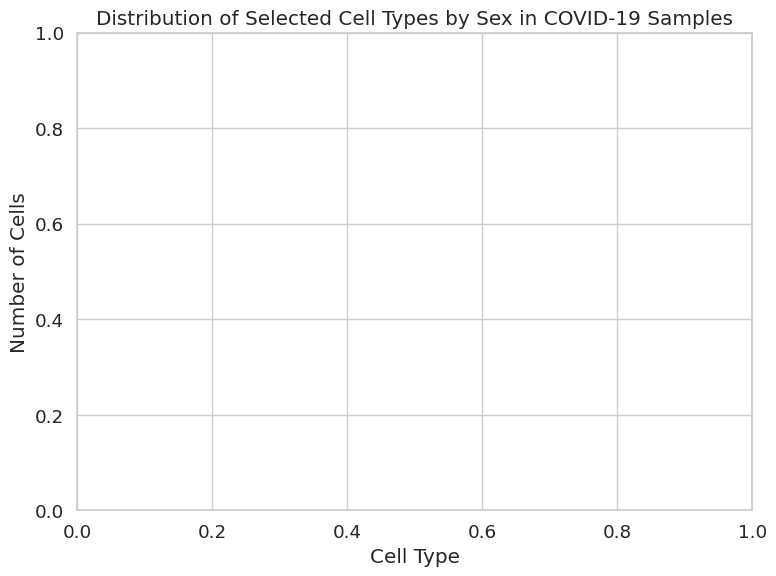


Summary of nCount_RNA by Sex:
Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []

Summary of percent_mt by Sex:
Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# First step: Subset the data to only include COVID samples and selected cell types
# Assuming adata is already loaded in memory

# Subset to COVID patients based on the Status column
covid_mask = adata.obs['Status'].astype(str).str.contains('COVID')
covid_adata = adata[covid_mask].copy()

# Define the cell types of interest based on cell_type_coarse annotation
cell_types_interest = ["b'CD14 Monocyte'", "b'CD16 Monocyte'", "b'CD4 T'", "b'CD8 T'"]
celltype_mask = covid_adata.obs['cell_type_coarse'].isin(cell_types_interest)
covid_subset = covid_adata[celltype_mask].copy()

# Print a summary of cell counts by Sex for each selected cell type
summary = covid_subset.obs.groupby(['cell_type_coarse', 'Sex']).size().unstack(fill_value=0)
print('Cell counts by cell type and Sex in COVID-19 samples:')
print(summary)

# Additionally, plot the distribution as a barplot for visualization
summary_plot = summary.reset_index().melt(id_vars='cell_type_coarse', var_name='Sex', value_name='CellCount')
plt.figure(figsize=(8, 6))
sns.barplot(data=summary_plot, x='cell_type_coarse', y='CellCount', hue='Sex')
plt.title('Distribution of Selected Cell Types by Sex in COVID-19 Samples')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.tight_layout()
plt.show()

# Also, summarize basic quality metrics by Sex to ensure no obvious biases (e.g., nCount_RNA, percent_mt)
quality_metrics = ['nCount_RNA', 'percent_mt']
for metric in quality_metrics:
    print(f"\nSummary of {metric} by Sex:")
    print(covid_subset.obs.groupby('Sex')[metric].describe())